In [181]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from scipy import sparse
import statsmodels.api as sm
from sklearn.pipeline import make_pipeline, Pipeline

In [2]:
df = pd.read_csv('buyouts_funds/buyouts_funds_csv/buyouts_funds_final.csv')

In [3]:
df.head()

,fund_id,fund_name,fm_id,strategy,sector,region,country,target_fund_size_amt,target_fund_size_currency,fund_size_amt,fund_currency,status,stage,vintage_year,open_date
0,34866,Ascent Venture Partners VII,6381,Venture Capital / Growth Equity,TMT,North America,United States,150000000.0,USD,NaN,NaN,Launched,NaN,2020,2020-0
1,43446,Volunteer Park Capital,19143,Mezzanine / Debt,Diversified,North America,NaN,200000000.0,USD,30000000.0,USD,Currently Investing,1st Close,2019,2019-8
2,44723,Flashstarts Blockchain Fund,14468,Venture Capital / Growth Equity,TMT,North America,United States,6000000.0,USD,NaN,NaN,Launched,NaN,2019,2019-1
3,44727,Harmony Partners IV,10317,Venture Capital / Growth Equity,TMT,North America,United States,125000000.0,USD,NaN,NaN,Launched,NaN,2019,2019-1
4,44738,Light Street Beacon Principals I,19412,Venture Capital / Growth Equity,TMT,North America,United States,20000000.0,USD,NaN,NaN,Launched,NaN,2019,2019-1


#### Using all features in buyouts_funds_final to predict target_fund_size_amt

In [4]:
allfeatures = ['fund_id', 'fund_name', 'fm_id', 'strategy', 'sector',
              'region', 'country', 'target_fund_size_amt',
              'target_fund_size_currency', 'fund_size_amt', 'fund_currency',
              'status', 'stage', 'vintage_year', 'open_date']

In [5]:
for i in allfeatures:
    df[i] = df[i].fillna(0)

In [6]:
df['fund_name'] = pd.to_numeric(df['fund_name'], errors='coerce')
df['strategy'] = pd.to_numeric(df['strategy'], errors='coerce')
df['sector'] = pd.to_numeric(df['sector'], errors='coerce')
df['region'] = pd.to_numeric(df['region'], errors='coerce')
df['country'] = pd.to_numeric(df['country'], errors='coerce')
df['target_fund_size_currency'] = pd.to_numeric(df['target_fund_size_currency'], errors='coerce')
df['fund_currency'] = pd.to_numeric(df['fund_currency'], errors='coerce')
df['status'] = pd.to_numeric(df['status'], errors='coerce')
df['stage'] = pd.to_numeric(df['stage'], errors='coerce')
df['open_date'] = pd.to_numeric(df['open_date'], errors='coerce')

In [7]:
featurenames = ['fund_id', 'fund_name', 'fm_id', 'strategy', 'sector',
               'region', 'country', 'target_fund_size_currency',
                'fund_size_amt', 'fund_currency', 'status', 'stage',
                'vintage_year', 'open_date']

In [8]:
col_cat = ['fund_name', 'strategy', 'sector', 'region', 'country',
          'target_fund_size_currency', 'fund_currency', 'status',
          'stage', 'open_date']

col_num = ['fund_id', 'fm_id', 'fund_size_amt', 'vintage_year']

In [9]:
X = df[featurenames]
y = df.target_fund_size_amt

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,
                                                   random_state=0)

In [11]:
X_train_cat = X_train[col_cat]
X_train_num = X_train[col_num]

X_test_cat = X_test[col_cat]
X_test_num = X_test[col_num]

In [12]:
ohe = make_pipeline(SimpleImputer(strategy='constant'), OneHotEncoder())
X_train_cat_enc = ohe.fit_transform(X_train_cat)
X_test_cat_enc = ohe.fit_transform(X_test_cat)

scaler_num = make_pipeline(StandardScaler(), SimpleImputer())
X_train_num_scaled = scaler_num.fit_transform(X_train_num)
X_test_num_scaled = scaler_num.fit_transform(X_test_num)

In [13]:
X_train_scaled = sparse.hstack((X_train_cat_enc,
                                sparse.csr_matrix(X_train_num_scaled)))
X_test_scaled = sparse.hstack((X_test_cat_enc,
                               sparse.csr_matrix(X_test_num_scaled)))

In [14]:
pipe_lasso = make_pipeline(Lasso(alpha=100, max_iter=1000))

In [15]:
lasso = pipe_lasso.fit(X_train_scaled, y_train)

In [16]:
print("Test set score: {:.2f}".format(lasso.score(X_test_scaled, y_test)))
print("Number of features used:", np.sum(lasso['lasso'].coef_ != 0))

Test set score: 0.22
Number of features used: 4


In [17]:
param_grid={'lasso__alpha': np.logspace(1,7,num=13),
           'lasso__max_iter': [10000]}

In [18]:
grid = GridSearchCV(pipe_lasso, param_grid=param_grid, cv=10, n_jobs=-1)

In [19]:
grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=10, estimator=Pipeline(steps=[('lasso', Lasso(alpha=100))]),
             n_jobs=-1,
             param_grid={'lasso__alpha': array([1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03, 3.16227766e+03, 1.00000000e+04, 3.16227766e+04,
       1.00000000e+05, 3.16227766e+05, 1.00000000e+06, 3.16227766e+06,
       1.00000000e+07]),
                         'lasso__max_iter': [10000]})

In [20]:
print("Score for the best model: {:.2f}".format(grid.score(X_test_scaled,
                                                           y_test)))

Score for the best model: 0.22


In [21]:
grid.best_params_

{'lasso__alpha': 31622.776601683792, 'lasso__max_iter': 10000}

In [22]:
grid.best_estimator_

Pipeline(steps=[('lasso', Lasso(alpha=31622.776601683792, max_iter=10000))])

In [23]:
X_train.columns[(lasso['lasso'].coef_) != 0]

Index(['status', 'stage', 'vintage_year', 'open_date'], dtype='object')

#### Using all features in buyouts_funds_final to predict fund_size_amt

In [24]:
featurenames2 = ['fund_id', 'fund_name', 'fm_id', 'strategy', 'sector',
               'region', 'country', 'target_fund_size_amt',
                 'target_fund_size_currency', 'fund_currency', 'status',
                 'stage', 'vintage_year', 'open_date']

In [25]:
col_cat2 = ['fund_name', 'strategy', 'sector', 'region', 'country',
          'target_fund_size_currency', 'fund_currency', 'status',
          'stage', 'open_date']

col_num2 = ['fund_id', 'fm_id', 'target_fund_size_amt', 'vintage_year']

In [26]:
X2 = df[featurenames2]
y2 = df.fund_size_amt

In [27]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.1,
                                                   random_state=0)

In [28]:
X_train_cat2 = X_train2[col_cat2]
X_train_num2 = X_train2[col_num2]

X_test_cat2 = X_test2[col_cat2]
X_test_num2 = X_test2[col_num2]

In [29]:
ohe2 = make_pipeline(SimpleImputer(strategy='constant'), OneHotEncoder())
X_train_cat_enc2 = ohe2.fit_transform(X_train_cat2)
X_test_cat_enc2 = ohe2.fit_transform(X_test_cat2)

scaler_num2 = make_pipeline(StandardScaler(), SimpleImputer())
X_train_num_scaled2 = scaler_num2.fit_transform(X_train_num2)
X_test_num_scaled2 = scaler_num2.fit_transform(X_test_num2)

In [30]:
X_train_scaled2 = sparse.hstack((X_train_cat_enc2,
                                sparse.csr_matrix(X_train_num_scaled2)))
X_test_scaled2 = sparse.hstack((X_test_cat_enc2,
                               sparse.csr_matrix(X_test_num_scaled2)))

In [31]:
pipe_lasso2 = make_pipeline(Lasso(alpha=100, max_iter=1000))

In [32]:
lasso2 = pipe_lasso2.fit(X_train_scaled2, y_train2)

In [33]:
print("Test set score: {:.2f}".format(lasso2.score(X_test_scaled2, y_test2)))
print("Number of features used:", np.sum(lasso2['lasso'].coef_ != 0))

Test set score: 0.16
Number of features used: 4


In [34]:
param_grid2={'lasso__alpha': np.logspace(1,7,num=13),
           'lasso__max_iter': [10000]}

In [35]:
grid2 = GridSearchCV(pipe_lasso2, param_grid=param_grid2, cv=10, n_jobs=-1)

In [36]:
grid2.fit(X_train_scaled2, y_train2)

GridSearchCV(cv=10, estimator=Pipeline(steps=[('lasso', Lasso(alpha=100))]),
             n_jobs=-1,
             param_grid={'lasso__alpha': array([1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03, 3.16227766e+03, 1.00000000e+04, 3.16227766e+04,
       1.00000000e+05, 3.16227766e+05, 1.00000000e+06, 3.16227766e+06,
       1.00000000e+07]),
                         'lasso__max_iter': [10000]})

In [37]:
print("Score for the best model: {:.2f}".format(grid2.score(X_test_scaled2,
                                                           y_test2)))

Score for the best model: 0.17


In [38]:
grid2.best_params_

{'lasso__alpha': 1000000.0, 'lasso__max_iter': 10000}

In [39]:
grid2.best_estimator_

Pipeline(steps=[('lasso', Lasso(alpha=1000000.0, max_iter=10000))])

In [40]:
X_train2.columns[(lasso2['lasso'].coef_) != 0]

Index(['status', 'stage', 'vintage_year', 'open_date'], dtype='object')

#### Using all features in buyouts_fm_fund_history to predict fund_size_amt

In [45]:
df2 = pd.read_csv('buyouts_funds/buyouts_funds_csv/buyouts_fm_fund_history.csv')

In [46]:
df2.head()

,fm_fund_history_id,fm_id,fund_id,vintage_year,region,sector,strategy,fund_size_amt,fund_currency,target_fund_size_amt,target_fund_size_currency
0,14485,6381,6420,1995,North America,TMT,Venture Capital / Growth Equity,80000000.0,USD,0.0,USD
1,16781,6381,8305,2004,North America,TMT,Venture Capital / Growth Equity,140000000.0,USD,0.0,USD
2,29687,6381,9222,2008,North America,TMT,Venture Capital / Growth Equity,81750000.0,USD,81750000.0,USD
3,15051,6381,12856,1999,North America,TMT,Venture Capital / Growth Equity,115000000.0,USD,0.0,USD
4,29651,6381,34846,2015,North America,TMT,Venture Capital / Growth Equity,71050000.0,USD,150000000.0,USD


In [47]:
allfeatures2 = ['fm_fund_history_id', 'fm_id', 'fund_id', 'vintage_year', 'region', 'sector',
               'strategy', 'fund_size_amt', 'fund_currency', 'target_fund_size_amt',
               'target_fund_size_currency']

In [49]:
for i in allfeatures2:
    df2[i] = df2[i].fillna(0)

In [54]:
df2['region'] = pd.to_numeric(df2['region'], errors='coerce')
df2['sector'] = pd.to_numeric(df2['sector'], errors='coerce')
df2['strategy'] = pd.to_numeric(df2['strategy'], errors='coerce')
df2['fund_currency'] = pd.to_numeric(df2['fund_currency'], errors='coerce')
df2['target_fund_size_currency'] = pd.to_numeric(df2['target_fund_size_currency'], errors='coerce')

In [55]:
featurenames3 = ['fm_fund_history_id', 'fm_id', 'fund_id', 'vintage_year', 'region',
                'sector', 'strategy', 'fund_currency', 'target_fund_size_amt',
                'target_fund_size_currency']

In [56]:
col_cat3 = ['region', 'sector', 'strategy', 'fund_currency', 'target_fund_size_currency']

col_num3 = ['fm_fund_history_id', 'fm_id', 'fund_id', 'vintage_year', 'target_fund_size_amt']

In [58]:
X3 = df2[featurenames3]
y3 = df2.fund_size_amt

In [59]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.1,
                                                   random_state=0)

In [60]:
X_train_cat3 = X_train3[col_cat3]
X_train_num3 = X_train3[col_num3]

X_test_cat3 = X_test3[col_cat3]
X_test_num3 = X_test3[col_num3]

In [61]:
ohe3 = make_pipeline(SimpleImputer(strategy='constant'), OneHotEncoder())
X_train_cat_enc3 = ohe3.fit_transform(X_train_cat3)
X_test_cat_enc3 = ohe3.fit_transform(X_test_cat3)

scaler_num3 = make_pipeline(StandardScaler(), SimpleImputer())
X_train_num_scaled3 = scaler_num3.fit_transform(X_train_num3)
X_test_num_scaled3 = scaler_num3.fit_transform(X_test_num3)

In [62]:
X_train_scaled3 = sparse.hstack((X_train_cat_enc3,
                                sparse.csr_matrix(X_train_num_scaled3)))
X_test_scaled3 = sparse.hstack((X_test_cat_enc3,
                               sparse.csr_matrix(X_test_num_scaled3)))

In [63]:
pipe_lasso3 = make_pipeline(Lasso(alpha=100, max_iter=1000))

In [64]:
lasso3 = pipe_lasso3.fit(X_train_scaled3, y_train3)

In [65]:
print("Test set score: {:.2f}".format(lasso3.score(X_test_scaled3, y_test3)))
print("Number of features used:", np.sum(lasso3['lasso'].coef_ != 0))

Test set score: -1.51
Number of features used: 5


In [66]:
param_grid3={'lasso__alpha': np.logspace(1,7,num=13),
           'lasso__max_iter': [10000]}

In [67]:
grid3 = GridSearchCV(pipe_lasso3, param_grid=param_grid3, cv=10, n_jobs=-1)

In [68]:
grid3.fit(X_train_scaled3, y_train3)

GridSearchCV(cv=10, estimator=Pipeline(steps=[('lasso', Lasso(alpha=100))]),
             n_jobs=-1,
             param_grid={'lasso__alpha': array([1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03, 3.16227766e+03, 1.00000000e+04, 3.16227766e+04,
       1.00000000e+05, 3.16227766e+05, 1.00000000e+06, 3.16227766e+06,
       1.00000000e+07]),
                         'lasso__max_iter': [10000]})

In [69]:
grid3.best_params_

{'lasso__alpha': 10000000.0, 'lasso__max_iter': 10000}

In [70]:
grid3.best_estimator_

Pipeline(steps=[('lasso', Lasso(alpha=10000000.0, max_iter=10000))])

In [75]:
X_train3.columns[(lasso3['lasso'].coef_) != 0]

Index(['sector', 'strategy', 'fund_currency', 'target_fund_size_amt',
       'target_fund_size_currency'],
      dtype='object')

#### Using all features in buyouts_fm_fund_history to predict target_fund_size_amt

In [76]:
featurenames4 = ['fm_fund_history_id', 'fm_id', 'fund_id', 'vintage_year', 'region',
                'sector', 'strategy', 'fund_size_amt', 'fund_currency',
                'target_fund_size_currency']

In [78]:
col_cat4 = ['region', 'sector', 'strategy', 'fund_currency', 'target_fund_size_currency']

col_num4 = ['fm_fund_history_id', 'fm_id', 'fund_id', 'vintage_year', 'fund_size_amt']

In [79]:
X4 = df2[featurenames4]
y4 = df2.target_fund_size_amt

In [80]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.1,
                                                   random_state=0)

In [81]:
X_train_cat4 = X_train4[col_cat4]
X_train_num4 = X_train4[col_num4]

X_test_cat4 = X_test4[col_cat4]
X_test_num4 = X_test4[col_num4]

In [82]:
ohe4 = make_pipeline(SimpleImputer(strategy='constant'), OneHotEncoder())
X_train_cat_enc4 = ohe4.fit_transform(X_train_cat4)
X_test_cat_enc4 = ohe4.fit_transform(X_test_cat4)

scaler_num4 = make_pipeline(StandardScaler(), SimpleImputer())
X_train_num_scaled4 = scaler_num4.fit_transform(X_train_num4)
X_test_num_scaled4 = scaler_num4.fit_transform(X_test_num4)

In [83]:
X_train_scaled4 = sparse.hstack((X_train_cat_enc4,
                                sparse.csr_matrix(X_train_num_scaled4)))
X_test_scaled4 = sparse.hstack((X_test_cat_enc4,
                               sparse.csr_matrix(X_test_num_scaled4)))

In [84]:
pipe_lasso4 = make_pipeline(Lasso(alpha=100, max_iter=1000))

In [85]:
lasso4 = pipe_lasso4.fit(X_train_scaled4, y_train4)

In [86]:
print("Test set score: {:.2f}".format(lasso4.score(X_test_scaled4, y_test4)))
print("Number of features used:", np.sum(lasso4['lasso'].coef_ != 0))

Test set score: -1.80
Number of features used: 5


In [87]:
param_grid4={'lasso__alpha': np.logspace(1,7,num=13),
           'lasso__max_iter': [10000]}

In [88]:
grid4 = GridSearchCV(pipe_lasso4, param_grid=param_grid4, cv=10, n_jobs=-1)

In [89]:
grid4.fit(X_train_scaled4, y_train4)

GridSearchCV(cv=10, estimator=Pipeline(steps=[('lasso', Lasso(alpha=100))]),
             n_jobs=-1,
             param_grid={'lasso__alpha': array([1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03, 3.16227766e+03, 1.00000000e+04, 3.16227766e+04,
       1.00000000e+05, 3.16227766e+05, 1.00000000e+06, 3.16227766e+06,
       1.00000000e+07]),
                         'lasso__max_iter': [10000]})

In [90]:
grid4.best_params_

{'lasso__alpha': 10000000.0, 'lasso__max_iter': 10000}

In [91]:
grid4.best_estimator_

Pipeline(steps=[('lasso', Lasso(alpha=10000000.0, max_iter=10000))])

In [92]:
X_train4.columns[(lasso4['lasso'].coef_) != 0]

Index(['sector', 'strategy', 'fund_size_amt', 'fund_currency',
       'target_fund_size_currency'],
      dtype='object')

#### Using all features in buyouts_historical_funds to predict fund_size_amt 

In [93]:
df3 = pd.read_csv('buyouts_funds/buyouts_funds_csv/buyouts_historical_funds.csv')

In [94]:
df3.head()

,fund_id,fund_name,manager_id,manager,close_year,strategy,fund_size_amt,fund_currency
0,23717,Warburg Pincus Associates,5591.0,Warburg Pincus,1980,Venture Capital / Growth Equity,101000000.0,USD
1,14874,Kleiner Perkins Caufield & Byers II,6562.0,Kleiner Perkins,1980,Venture Capital / Growth Equity,55000000.0,USD
2,10708,TA Associates / Advent IV,6694.0,TA Associates,1980,Venture Capital / Growth Equity,60000000.0,USD
3,15603,Excelsior Fund,6373.0,Apax Partners,1981,Venture Capital / Growth Equity,25530000.0,USD
4,15213,New Enterprise Associates II,6610.0,New Enterprise Associates,1981,Venture Capital / Growth Equity,45310000.0,USD


In [95]:
allfeatures3 = ['fund_id', 'fund_name', 'manager_id', 'manager', 'close_year', 'strategy',
               'fund_size_amt', 'fund_currency']

In [96]:
for i in allfeatures3:
    df3[i] = df3[i].fillna(0)

In [97]:
df3['fund_name'] = pd.to_numeric(df3['fund_name'], errors='coerce')
df3['manager'] = pd.to_numeric(df3['manager'], errors='coerce')
df3['strategy'] = pd.to_numeric(df3['strategy'], errors='coerce')
df3['fund_currency'] = pd.to_numeric(df3['fund_currency'], errors='coerce')

In [98]:
featurenames5 = ['fund_id', 'fund_name', 'manager_id', 'manager', 'close_year', 'strategy',
               'fund_currency']

In [99]:
col_cat5 = ['fund_name', 'manager', 'strategy', 'fund_currency']

col_num5 = ['fund_id', 'manager_id', 'close_year']

In [100]:
X5 = df3[featurenames5]
y5 = df3.fund_size_amt

In [101]:
X_train5, X_test5, y_train5, y_test5 = train_test_split(X5, y5, test_size=0.1,
                                                   random_state=0)

In [102]:
X_train_cat5 = X_train5[col_cat5]
X_train_num5 = X_train5[col_num5]

X_test_cat5 = X_test5[col_cat5]
X_test_num5 = X_test5[col_num5]

In [103]:
ohe5 = make_pipeline(SimpleImputer(strategy='constant'), OneHotEncoder())
X_train_cat_enc5 = ohe5.fit_transform(X_train_cat5)
X_test_cat_enc5 = ohe5.fit_transform(X_test_cat5)

scaler_num5 = make_pipeline(StandardScaler(), SimpleImputer())
X_train_num_scaled5 = scaler_num5.fit_transform(X_train_num5)
X_test_num_scaled5 = scaler_num5.fit_transform(X_test_num5)

In [104]:
X_train_scaled5 = sparse.hstack((X_train_cat_enc5,
                                sparse.csr_matrix(X_train_num_scaled5)))
X_test_scaled5 = sparse.hstack((X_test_cat_enc5,
                               sparse.csr_matrix(X_test_num_scaled5)))

In [105]:
pipe_lasso5 = make_pipeline(Lasso(alpha=100, max_iter=1000))

In [106]:
lasso5 = pipe_lasso5.fit(X_train_scaled5, y_train5)

In [107]:
print("Test set score: {:.2f}".format(lasso5.score(X_test_scaled5, y_test5)))
print("Number of features used:", np.sum(lasso5['lasso'].coef_ != 0))

ValueError: dimension mismatch

#### Using all features in lp_commitments to predict fund_size_amt

In [117]:
df_lp = pd.read_csv('buyouts_lp/buyouts_lp_csv/lp_commitments.csv')
df_lp.head()

,lp_commitment_id,lp_id,fund_id,fund_name,fund_manager_id,fund_manager,sectors,strategies,fund_size_amt,fund_size_currency,commitment_amt,commitment_currency,regions,vintage_year
0,215027,3,60421,Greenspring Global Partners V,7045,StepStone Group,Healthcare,Fund of Funds / Co-Investment,356190000.0,USD,NaN,NaN,Asia-Pacific,2011
1,195565,3,60421,Greenspring Global Partners V,7045,StepStone Group,TMT,Fund of Funds / Co-Investment,356190000.0,USD,NaN,NaN,Asia-Pacific,2011
2,181373,3,60421,Greenspring Global Partners V,7045,StepStone Group,Healthcare,Fund of Funds / Co-Investment,356190000.0,USD,NaN,NaN,Latin America,2011
3,125752,3,60421,Greenspring Global Partners V,7045,StepStone Group,TMT,Fund of Funds / Co-Investment,356190000.0,USD,NaN,NaN,Latin America,2011
4,88550,3,60421,Greenspring Global Partners V,7045,StepStone Group,Healthcare,Fund of Funds / Co-Investment,356190000.0,USD,NaN,NaN,Western Europe,2011


In [118]:
allfeatures_lp = ['lp_commitment_id', 'lp_id', 'fund_id', 'fund_name', 'fund_manager_id', 
                  'fund_manager', 'sectors', 'strategies', 'fund_size_amt', 'fund_size_currency',
                 'commitment_amt', 'commitment_currency', 'regions', 'vintage_year']

In [119]:
for i in allfeatures_lp:
    df_lp[i] = df_lp[i].fillna(0)

In [120]:
df_lp['fund_name'] = pd.to_numeric(df_lp['fund_name'], errors='coerce')
df_lp['fund_manager'] = pd.to_numeric(df_lp['fund_manager'], errors='coerce')
df_lp['sectors'] = pd.to_numeric(df_lp['sectors'], errors='coerce')
df_lp['strategies'] = pd.to_numeric(df_lp['strategies'], errors='coerce')
df_lp['fund_size_currency'] = pd.to_numeric(df_lp['fund_size_currency'], errors='coerce')
df_lp['commitment_currency'] = pd.to_numeric(df_lp['commitment_currency'], errors='coerce')
df_lp['regions'] = pd.to_numeric(df_lp['regions'], errors='coerce')

In [122]:
featurenames_lp = ['lp_commitment_id', 'lp_id', 'fund_id', 'fund_name', 'fund_manager_id', 
                  'fund_manager', 'sectors', 'strategies', 'fund_size_currency',
                 'commitment_amt', 'commitment_currency', 'regions', 'vintage_year']

In [124]:
col_cat_lp = ['fund_name', 'fund_name', 'fund_manager', 'sectors', 'strategies',
          'fund_size_currency', 'commitment_currency', 'regions']

col_num_lp = ['lp_commitment_id', 'lp_id', 'fund_id', 'fund_manager_id', 'commitment_amt', 'vintage_year']

In [125]:
X_lp = df_lp[featurenames_lp]
y_lp = df_lp.fund_size_amt

In [126]:
X_train_lp, X_test_lp, y_train_lp, y_test_lp = train_test_split(X_lp, y_lp, test_size=0.1,
                                                   random_state=0)

In [127]:
X_train_cat_lp = X_train_lp[col_cat_lp]
X_train_num_lp = X_train_lp[col_num_lp]

X_test_cat_lp = X_test_lp[col_cat_lp]
X_test_num_lp = X_test_lp[col_num_lp]

In [128]:
ohe_lp = make_pipeline(SimpleImputer(strategy='constant'), OneHotEncoder())
X_train_cat_enc_lp = ohe_lp.fit_transform(X_train_cat_lp)
X_test_cat_enc_lp = ohe_lp.fit_transform(X_test_cat_lp)

scaler_num = make_pipeline(StandardScaler(), SimpleImputer())
X_train_num_scaled_lp = scaler_num.fit_transform(X_train_num_lp)
X_test_num_scaled_lp = scaler_num.fit_transform(X_test_num_lp)

In [129]:
X_train_scaled_lp = sparse.hstack((X_train_cat_enc_lp,
                                sparse.csr_matrix(X_train_num_scaled_lp)))
X_test_scaled_lp = sparse.hstack((X_test_cat_enc_lp,
                               sparse.csr_matrix(X_test_num_scaled_lp)))

In [130]:
pipe_lasso_lp = make_pipeline(Lasso(alpha=100, max_iter=1000))

In [131]:
lasso_lp = pipe_lasso_lp.fit(X_train_scaled_lp, y_train_lp)

In [134]:
print("Test set score: {:.2f}".format(lasso_lp.score(X_test_scaled_lp, y_test_lp)))
print("Number of features used:", np.sum(lasso_lp['lasso'].coef_ != 0))

Test set score: -0.00
Number of features used: 8


#### Using all features in lp_commitments to predict commitment_amt

In [135]:
featurenames_lp2 = ['lp_commitment_id', 'lp_id', 'fund_id', 'fund_name', 'fund_manager_id', 
                  'fund_manager', 'sectors', 'strategies', 'fund_size_amt', 'fund_size_currency',
                    'commitment_currency', 'regions', 'vintage_year']

In [136]:
col_cat_lp2 = ['fund_name', 'fund_name', 'fund_manager', 'sectors', 'strategies',
          'fund_size_currency', 'commitment_currency', 'regions']

col_num_lp2 = ['lp_commitment_id', 'lp_id', 'fund_id', 'fund_manager_id', 
               'fund_size_amt', 'vintage_year']

In [137]:
X_lp2 = df_lp[featurenames_lp2]
y_lp2 = df_lp.commitment_amt

In [138]:
X_train_lp2, X_test_lp2, y_train_lp2, y_test_lp2 = train_test_split(X_lp2, y_lp2, test_size=0.1,
                                                   random_state=0)

In [139]:
X_train_cat_lp2 = X_train_lp2[col_cat_lp2]
X_train_num_lp2 = X_train_lp2[col_num_lp2]

X_test_cat_lp2 = X_test_lp2[col_cat_lp2]
X_test_num_lp2 = X_test_lp2[col_num_lp2]

In [140]:
ohe_lp2 = make_pipeline(SimpleImputer(strategy='constant'), OneHotEncoder())
X_train_cat_enc_lp2 = ohe_lp2.fit_transform(X_train_cat_lp2)
X_test_cat_enc_lp2 = ohe_lp2.fit_transform(X_test_cat_lp2)

scaler_num = make_pipeline(StandardScaler(), SimpleImputer())
X_train_num_scaled_lp2 = scaler_num.fit_transform(X_train_num_lp2)
X_test_num_scaled_lp2 = scaler_num.fit_transform(X_test_num_lp2)

In [141]:
X_train_scaled_lp2 = sparse.hstack((X_train_cat_enc_lp2,
                                sparse.csr_matrix(X_train_num_scaled_lp2)))
X_test_scaled_lp2 = sparse.hstack((X_test_cat_enc_lp2,
                               sparse.csr_matrix(X_test_num_scaled_lp2)))

In [142]:
pipe_lasso_lp2 = make_pipeline(Lasso(alpha=100, max_iter=1000))

In [143]:
lasso_lp2 = pipe_lasso_lp2.fit(X_train_scaled_lp2, y_train_lp2)

In [144]:
print("Test set score: {:.2f}".format(lasso_lp2.score(X_test_scaled_lp2, y_test_lp2)))
print("Number of features used:", np.sum(lasso_lp2['lasso'].coef_ != 0))

Test set score: -0.02
Number of features used: 7


#### Check times between each fund opening (lp_commitments.csv)

In [172]:
df_lp = pd.read_csv('buyouts_lp/buyouts_lp_csv/lp_commitments.csv')
df_lp

,lp_commitment_id,lp_id,fund_id,fund_name,fund_manager_id,fund_manager,sectors,strategies,fund_size_amt,fund_size_currency,commitment_amt,commitment_currency,regions,vintage_year
0,215027,3,60421,Greenspring Global Partners V,7045,StepStone Group,Healthcare,Fund of Funds / Co-Investment,3.561900e+08,USD,NaN,NaN,Asia-Pacific,2011
1,195565,3,60421,Greenspring Global Partners V,7045,StepStone Group,TMT,Fund of Funds / Co-Investment,3.561900e+08,USD,NaN,NaN,Asia-Pacific,2011
2,181373,3,60421,Greenspring Global Partners V,7045,StepStone Group,Healthcare,Fund of Funds / Co-Investment,3.561900e+08,USD,NaN,NaN,Latin America,2011
3,125752,3,60421,Greenspring Global Partners V,7045,StepStone Group,TMT,Fund of Funds / Co-Investment,3.561900e+08,USD,NaN,NaN,Latin America,2011
4,88550,3,60421,Greenspring Global Partners V,7045,StepStone Group,Healthcare,Fund of Funds / Co-Investment,3.561900e+08,USD,NaN,NaN,Western Europe,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243982,18970,22750,55145,Brookfield Global Transition Fund,5903,Brookfield Asset Management,Energy / Oil & Gas,Buyout / Corporate Private Equity,7.000000e+09,USD,20000000.0,USD,Middle East/Africa,2021
243983,45843,22750,55145,Brookfield Global Transition Fund,5903,Brookfield Asset Management,Energy / Oil & Gas,Buyout / Corporate Private Equity,7.000000e+09,USD,20000000.0,USD,Asia-Pacific,2021
243984,176146,22750,55145,Brookfield Global Transition Fund,5903,Brookfield Asset Management,Energy / Oil & Gas,Buyout / Corporate Private Equity,7.000000e+09,USD,20000000.0,USD,Central/Eastern Europe,2021
243985,24658,22750,60617,Genesia Venture Fund III,19397,Genesia Ventures,Leisure,Venture Capital / Growth Equity,1.000000e+10,JPY,NaN,NaN,Asia-Pacific,2022


In [167]:
allfeatures_lp = ['lp_commitment_id', 'lp_id', 'fund_id', 'fund_name', 'fund_manager_id', 
                  'fund_manager', 'sectors', 'strategies', 'fund_size_amt', 'fund_size_currency',
                 'commitment_amt', 'commitment_currency', 'regions', 'vintage_year']

In [168]:
for i in allfeatures_lp:
    df_lp[i] = df_lp[i].fillna(0)

In [277]:
df_open = df_lp.groupby('fund_manager').vintage_year.apply(lambda x: x.diff().dropna().mean())

In [278]:
df_open = df_open.dropna().abs()
df_open

fund_manager
.406 Ventures         0.312500
1315 Capital          0.000000
15th Rock Ventures    0.000000
17Capital             0.033898
21 Invest             0.333333
                        ...   
iNetworks             0.000000
iXO Private Equity    0.250000
idi EM Partners       0.000000
pi Ventures           0.000000
rocketship.vc         0.000000
Name: vintage_year, Length: 3715, dtype: float64

In [275]:
df_open = df_open.abs()
df_open

fund_manager
.406 Ventures         0.312500
1315 Capital          0.000000
15th Rock Ventures    0.000000
17Capital             0.033898
21 Invest             0.333333
                        ...   
iNetworks             0.000000
iXO Private Equity    0.250000
idi EM Partners       0.000000
pi Ventures           0.000000
rocketship.vc         0.000000
Name: vintage_year, Length: 3715, dtype: float64

In [279]:
df_open.sort_values(ascending=True, inplace=True)
df_open

fund_manager
rocketship.vc                          0.0
Hyperion Israel                        0.0
Hyde Park Venture Partners             0.0
Hustle Fund                            0.0
Hupomone Capital Partners              0.0
                                      ... 
Dogan                                 12.0
High-Tech GrÃ¼nderfonds Management    12.0
StageOne Ventures                     13.0
Five Points Capital                   18.0
NVM Private Equity                    33.0
Name: vintage_year, Length: 3715, dtype: float64

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500., 3000., 3500.,
        4000.]),
 [Text(-500.0, 0, 'Navigation Capital Partners'),
  Text(0.0, 0, 'rocketship.vc'),
  Text(500.0, 0, 'Taurus Private Markets'),
  Text(1000.0, 0, 'Mistral Equity Partners'),
  Text(1500.0, 0, 'Windward Capital Partners'),
  Text(2000.0, 0, 'Cerberus Capital Management'),
  Text(2500.0, 0, 'Montefiore Investment'),
  Text(3000.0, 0, 'VNT Management'),
  Text(3500.0, 0, 'SpaceVest'),
  Text(4000.0, 0, '')])

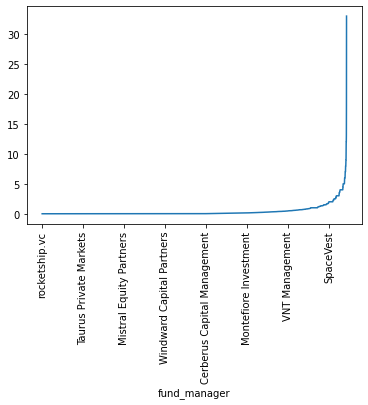

In [285]:
df_open.plot()
plt.xticks(rotation='vertical')

In [281]:
df_lp[df_lp.fund_manager=='Five Points Capital']

,lp_commitment_id,lp_id,fund_id,fund_name,fund_manager_id,fund_manager,sectors,strategies,fund_size_amt,fund_size_currency,commitment_amt,commitment_currency,regions,vintage_year
168407,11583,3500,35190,Five Points Mezzanine Fund III,7940,Five Points Capital,Diversified,Mezzanine / Debt,290000000.0,USD,NaN,NaN,North America,2016
207831,45105,12486,4769,BB&T Capital Partners,7940,Five Points Capital,Diversified,Buyout / Corporate Private Equity,101000000.0,USD,NaN,NaN,North America,1998


In [282]:
df_lp[df_lp.fund_manager=='NVM Private Equity']

,lp_commitment_id,lp_id,fund_id,fund_name,fund_manager_id,fund_manager,sectors,strategies,fund_size_amt,fund_size_currency,commitment_amt,commitment_currency,regions,vintage_year
120822,190775,1512,10825,Northern Investors Company,5340,NVM Private Equity,Business Services,Buyout / Corporate Private Equity,57000000.0,GBP,500000.0,GBP,Western Europe,1984
184729,24075,4259,42963,NVM Private Equity Vintage III,5340,NVM Private Equity,Business Services,Buyout / Corporate Private Equity,142000000.0,GBP,NaN,NaN,Western Europe,2017


#### Find top 15 fund managers with the longest length of time between funds

In [431]:
df_top15 = df_open.nlargest(15)
df_top15

fund_manager
NVM Private Equity                        33.0
Five Points Capital                       18.0
StageOne Ventures                         13.0
Dogan                                     12.0
High-Tech GrÃ¼nderfonds Management        12.0
Ludgate Investments                       11.0
BTS Investment Advisors                    9.0
Artá Capital                               9.0
Spell Capital Partners                     9.0
Strength Capital                           8.0
Affirma Capital                            8.0
Baring Private Equity Partners EspaÃ±a     8.0
Altimeter Capital Management               8.0
Somerset Indus Capital Partners            7.0
Adara Ventures                             7.0
Name: vintage_year, dtype: float64

In [432]:
df_top15fm = df_top15.index.tolist()
df_top15fm

['NVM Private Equity',
 'Five Points Capital',
 'StageOne Ventures',
 'Dogan',
 'High-Tech GrÃ¼nderfonds Management',
 'Ludgate Investments',
 'BTS Investment Advisors',
 'Artá Capital',
 'Spell Capital Partners',
 'Strength Capital',
 'Affirma Capital',
 'Baring Private Equity Partners EspaÃ±a',
 'Altimeter Capital Management',
 'Somerset Indus Capital Partners',
 'Adara Ventures']

In [433]:
df_top15years = df_top15.values.tolist()
df_top15years

[33.0,
 18.0,
 13.0,
 12.0,
 12.0,
 11.0,
 9.0,
 9.0,
 9.0,
 8.0,
 8.0,
 8.0,
 8.0,
 7.0,
 7.0]

In [434]:
df_lp_top15 = df_lp.query('fund_manager in @df_top15fm')
df_lp_top15

,lp_commitment_id,lp_id,fund_id,fund_name,fund_manager_id,fund_manager,sectors,strategies,fund_size_amt,fund_size_currency,commitment_amt,commitment_currency,regions,vintage_year
5815,140417,55,39637,Hightech Grunderfonds III,12040,High-Tech GrÃ¼nderfonds Management,TMT,Venture Capital / Growth Equity,3.165000e+08,EUR,NaN,NaN,Western Europe,2017
18841,40275,145,5790,Spell Capital Partners Fund I,7439,Spell Capital Partners,Industrials,Buyout / Corporate Private Equity,2.500000e+07,USD,0.0,USD,North America,1997
52606,34822,362,34272,Somerset Indus Healthcare Fund II,12379,Somerset Indus Capital Partners,Healthcare,Buyout / Corporate Private Equity,0.000000e+00,USD,25000000.0,USD,Asia-Pacific,2018
73859,238944,475,26015,Spell Capital Partners Fund III,7439,Spell Capital Partners,Industrials,Buyout / Corporate Private Equity,6.500000e+07,USD,NaN,NaN,North America,2006
109145,190939,1089,7183,Strength Capital Partners II,8125,Strength Capital,Diversified,Buyout / Corporate Private Equity,1.000000e+08,USD,8000000.0,USD,North America,2005
118372,153315,1433,10352,Baring Iberia III,5394,Baring Private Equity Partners EspaÃ±a,Diversified,Venture Capital / Growth Equity,1.520000e+08,EUR,50000000.0,DKK,Western Europe,2006
119121,86058,1472,4878,Hightech Grunderfonds I,12040,High-Tech GrÃ¼nderfonds Management,TMT,Venture Capital / Growth Equity,2.720000e+08,EUR,0.0,USD,Western Europe,2005
120822,190775,1512,10825,Northern Investors Company,5340,NVM Private Equity,Business Services,Buyout / Corporate Private Equity,5.700000e+07,GBP,500000.0,GBP,Western Europe,1984
123737,149173,1625,10812,Baring Iberia,5394,Baring Private Equity Partners EspaÃ±a,Diversified,Venture Capital / Growth Equity,6.000000e+07,EUR,0.0,USD,Western Europe,1998
123971,106380,1649,1179,Somerset Indus Healthcare Fund I,12379,Somerset Indus Capital Partners,Healthcare,Buyout / Corporate Private Equity,5.000000e+07,USD,240000000.0,INR,Asia-Pacific,2011


In [435]:
df_lp_grouped = df_lp_top15.sort_values('fund_manager')
df_lp_grouped = df_lp_grouped[df_lp_grouped['fund_size_currency']=='USD']
df_lp_grouped['time_bw_vintageyears'] = df_top15years
df_lp_grouped.sort_values('time_bw_vintageyears')

,lp_commitment_id,lp_id,fund_id,fund_name,fund_manager_id,fund_manager,sectors,strategies,fund_size_amt,fund_size_currency,commitment_amt,commitment_currency,regions,vintage_year,time_bw_vintageyears
203252,175852,8019,28953,Strength Capital Partners III - Special Situat...,8125,Strength Capital,Diversified,Buyout / Corporate Private Equity,61000000.0,USD,0.0,USD,North America,2013,7.0
109145,190939,1089,7183,Strength Capital Partners II,8125,Strength Capital,Diversified,Buyout / Corporate Private Equity,100000000.0,USD,8000000.0,USD,North America,2005,7.0
73859,238944,475,26015,Spell Capital Partners Fund III,7439,Spell Capital Partners,Industrials,Buyout / Corporate Private Equity,65000000.0,USD,NaN,NaN,North America,2006,8.0
18841,40275,145,5790,Spell Capital Partners Fund I,7439,Spell Capital Partners,Industrials,Buyout / Corporate Private Equity,25000000.0,USD,0.0,USD,North America,1997,8.0
150525,222926,2326,30257,StageOne Venture Capital Fund II,8662,StageOne Ventures,TMT,Venture Capital / Growth Equity,65000000.0,USD,6000000.0,USD,Middle East/Africa,2014,8.0
150506,194286,2326,9167,StageOne Ventures,8662,StageOne Ventures,TMT,Venture Capital / Growth Equity,46000000.0,USD,18800000.0,USD,Middle East/Africa,2001,8.0
152440,88483,2403,21874,Ludgate Industrial & Resource Efficiency Fund II,5327,Ludgate Investments,Energy / Oil & Gas,Venture Capital / Growth Equity,0.0,USD,6000000.0,GBP,Western Europe,2012,9.0
123971,106380,1649,1179,Somerset Indus Healthcare Fund I,12379,Somerset Indus Capital Partners,Healthcare,Buyout / Corporate Private Equity,50000000.0,USD,240000000.0,INR,Asia-Pacific,2011,9.0
52606,34822,362,34272,Somerset Indus Healthcare Fund II,12379,Somerset Indus Capital Partners,Healthcare,Buyout / Corporate Private Equity,0.0,USD,25000000.0,USD,Asia-Pacific,2018,9.0
168407,11583,3500,35190,Five Points Mezzanine Fund III,7940,Five Points Capital,Diversified,Mezzanine / Debt,290000000.0,USD,NaN,NaN,North America,2016,11.0


In [436]:
topcorr = df_lp_grouped['fund_size_amt'].corr(df_lp_grouped['time_bw_vintageyears'])
topcorr

-0.16113965273041717

In [437]:
topcorr2 = df_lp_grouped['commitment_amt'].corr(df_lp_grouped['time_bw_vintageyears'])
topcorr2

0.28303600757704933

In [491]:
topcorr3 = df_lp_grouped['fund_size_amt'].corr(df_lp_grouped['commitment_amt'])
topcorr3

-0.08930994023020115

#### Find top 40 fund managers with the longest length of time between funds

In [471]:
df_top40 = df_open.nlargest(40)
df_top40

fund_manager
NVM Private Equity                        33.0
Five Points Capital                       18.0
StageOne Ventures                         13.0
Dogan                                     12.0
High-Tech GrÃ¼nderfonds Management        12.0
Ludgate Investments                       11.0
BTS Investment Advisors                    9.0
Artá Capital                               9.0
Spell Capital Partners                     9.0
Strength Capital                           8.0
Affirma Capital                            8.0
Baring Private Equity Partners EspaÃ±a     8.0
Altimeter Capital Management               8.0
Somerset Indus Capital Partners            7.0
Adara Ventures                             7.0
CCP Equity Partners                        7.0
Azini Capital                              7.0
Claret Capital Partners                    7.0
Resolute Capital Partners (Nashville)      6.0
Laguna Bay                                 6.0
GreenSoil Investments                      6.0


In [472]:
df_top40fm = df_top40.index.tolist()
df_top40fm

['NVM Private Equity',
 'Five Points Capital',
 'StageOne Ventures',
 'Dogan',
 'High-Tech GrÃ¼nderfonds Management',
 'Ludgate Investments',
 'BTS Investment Advisors',
 'Artá Capital',
 'Spell Capital Partners',
 'Strength Capital',
 'Affirma Capital',
 'Baring Private Equity Partners EspaÃ±a',
 'Altimeter Capital Management',
 'Somerset Indus Capital Partners',
 'Adara Ventures',
 'CCP Equity Partners',
 'Azini Capital',
 'Claret Capital Partners',
 'Resolute Capital Partners (Nashville)',
 'Laguna Bay',
 'GreenSoil Investments',
 'Seoul Investment Partners',
 'Monarch Alternative Capital',
 'Aksìa Group',
 'Next Wave Funds',
 'Treadstone Energy Partners',
 'UTEC',
 'Rally Ventures',
 'Newable',
 'Paragon Venture Partners',
 'Charter Life Sciences Ventures',
 'Volta Ventures',
 'Spindletop Capital',
 'Health Enterprise Partners',
 'Armory Square Ventures',
 'Tenth Street Capital',
 'Japan Asia Investment',
 'Lazard Australia Private Equity',
 'TechOperators',
 'Saw Mill Capital']

In [473]:
df_top40years = df_top40.values.tolist()
df_top40years

[33.0,
 18.0,
 13.0,
 12.0,
 12.0,
 11.0,
 9.0,
 9.0,
 9.0,
 8.0,
 8.0,
 8.0,
 8.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 6.0,
 5.5,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0,
 5.0]

In [474]:
df_lp_top40 = df_lp.query('fund_manager in @df_top40fm')
df_lp_top40

,lp_commitment_id,lp_id,fund_id,fund_name,fund_manager_id,fund_manager,sectors,strategies,fund_size_amt,fund_size_currency,commitment_amt,commitment_currency,regions,vintage_year
2453,227275,28,24247,Spindletop Healthcare Capital,12822,Spindletop Capital,Healthcare,Venture Capital / Growth Equity,5.051000e+07,USD,NaN,NaN,North America,2011
2467,138732,28,36985,Spindletop Healthcare Growth Capital II,12822,Spindletop Capital,Healthcare,Buyout / Corporate Private Equity,0.000000e+00,USD,NaN,NaN,North America,2016
5815,140417,55,39637,Hightech Grunderfonds III,12040,High-Tech GrÃ¼nderfonds Management,TMT,Venture Capital / Growth Equity,3.165000e+08,EUR,NaN,NaN,Western Europe,2017
14358,141052,93,7877,Conning Capital Partners VI,6447,CCP Equity Partners,Financial Services,Buyout / Corporate Private Equity,2.760000e+08,USD,0.000000e+00,USD,North America,1999
17870,87131,127,43300,UTEC Investment Limited Partnership No. 4,10252,UTEC,TMT,Venture Capital / Growth Equity,2.425000e+10,JPY,2.430000e+10,JPY,Asia-Pacific,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222693,42745,15140,54763,Harbert European Growth Capital Fund I,21816,Claret Capital Partners,TMT,Mezzanine / Debt,1.220000e+08,EUR,1.000000e+08,EUR,Western Europe,2013
224584,76675,15532,29945,Altimeter Private Partners Fund I,14801,Altimeter Capital Management,TMT,Venture Capital / Growth Equity,7.500000e+07,USD,NaN,NaN,North America,2013
228126,66203,16153,54764,Harbert / Claret European Growth Capital Fund III,21816,Claret Capital Partners,TMT,Mezzanine / Debt,0.000000e+00,EUR,4.000000e+07,EUR,Western Europe,2020
233564,204360,16954,27826,Greensoil PropTech Ventures Fund I,13634,GreenSoil Investments,TMT,Venture Capital / Growth Equity,5.900000e+07,USD,NaN,NaN,North America,2015


In [475]:
df_lp_grouped2 = df_lp_top40.sort_values('fund_manager')
df_lp_grouped2 = df_lp_grouped2[df_lp_grouped2['fund_size_currency']=='USD']
df_lp_grouped2 = df_lp_grouped2[df_lp_grouped2['commitment_currency']=='USD']

In [476]:
df_top40_new = df_top40.filter(df_lp_grouped2['fund_manager'])
df_top40_new

fund_manager
Altimeter Capital Management              8.0
Armory Square Ventures                    5.0
BTS Investment Advisors                   9.0
BTS Investment Advisors                   9.0
CCP Equity Partners                       7.0
CCP Equity Partners                       7.0
CCP Equity Partners                       7.0
Charter Life Sciences Ventures            5.0
Charter Life Sciences Ventures            5.0
Japan Asia Investment                     5.0
Monarch Alternative Capital               6.0
Paragon Venture Partners                  5.0
Paragon Venture Partners                  5.0
Rally Ventures                            5.0
Resolute Capital Partners (Nashville)     6.0
Saw Mill Capital                          5.0
Saw Mill Capital                          5.0
Saw Mill Capital                          5.0
Somerset Indus Capital Partners           7.0
Spell Capital Partners                    9.0
StageOne Ventures                        13.0
StageOne Ventures    

In [477]:
df_top40_newfm = df_top40_new.index.tolist()
df_top40_newfm

['Altimeter Capital Management',
 'Armory Square Ventures',
 'BTS Investment Advisors',
 'BTS Investment Advisors',
 'CCP Equity Partners',
 'CCP Equity Partners',
 'CCP Equity Partners',
 'Charter Life Sciences Ventures',
 'Charter Life Sciences Ventures',
 'Japan Asia Investment',
 'Monarch Alternative Capital',
 'Paragon Venture Partners',
 'Paragon Venture Partners',
 'Rally Ventures',
 'Resolute Capital Partners (Nashville)',
 'Saw Mill Capital',
 'Saw Mill Capital',
 'Saw Mill Capital',
 'Somerset Indus Capital Partners',
 'Spell Capital Partners',
 'StageOne Ventures',
 'StageOne Ventures',
 'Strength Capital',
 'Strength Capital',
 'Treadstone Energy Partners',
 'Treadstone Energy Partners']

In [478]:
df_top40_newyears = df_top40_new.values.tolist()
df_top40_newyears

[8.0,
 5.0,
 9.0,
 9.0,
 7.0,
 7.0,
 7.0,
 5.0,
 5.0,
 5.0,
 6.0,
 5.0,
 5.0,
 5.0,
 6.0,
 5.0,
 5.0,
 5.0,
 7.0,
 9.0,
 13.0,
 13.0,
 8.0,
 8.0,
 5.5,
 5.5]

In [479]:
df_lp_grouped2['time_bw_vintageyears'] = df_top40_newyears
df_lp_grouped2.sort_values('time_bw_vintageyears')
df_lp_grouped2

,lp_commitment_id,lp_id,fund_id,fund_name,fund_manager_id,fund_manager,sectors,strategies,fund_size_amt,fund_size_currency,commitment_amt,commitment_currency,regions,vintage_year,time_bw_vintageyears
204612,51799,10353,60147,Altimeter Growth Partners Fund VI,14801,Altimeter Capital Management,TMT,Venture Capital / Growth Equity,0.000000e+00,USD,100000000.0,USD,North America,2021,8.0
158888,95651,2787,42941,Armory Square Ventures II,15505,Armory Square Ventures,TMT,Venture Capital / Growth Equity,3.100000e+07,USD,10000000.0,USD,North America,2018,5.0
149063,72999,2287,7094,Swiss Technology Venture Capital Fund,8012,BTS Investment Advisors,TMT,Venture Capital / Growth Equity,2.150000e+07,USD,21000000.0,USD,Asia-Pacific,1997,9.0
149060,164324,2287,6886,BTS India Private Equity Fund,8012,BTS Investment Advisors,Diversified,Venture Capital / Growth Equity,7.350000e+07,USD,12000000.0,USD,Asia-Pacific,2006,9.0
74090,226180,477,8707,Conning Insurance Capital,6447,CCP Equity Partners,Financial Services,Buyout / Corporate Private Equity,0.000000e+00,USD,0.0,USD,North America,1985,7.0
65434,238639,452,12741,Conning Capital Partners V,6447,CCP Equity Partners,Financial Services,Buyout / Corporate Private Equity,2.250000e+08,USD,0.0,USD,North America,1997,7.0
14358,141052,93,7877,Conning Capital Partners VI,6447,CCP Equity Partners,Financial Services,Buyout / Corporate Private Equity,2.760000e+08,USD,0.0,USD,North America,1999,7.0
137313,77595,1974,8045,Charter Life Sciences II,7564,Charter Life Sciences Ventures,Biotech / Life Science,Venture Capital / Growth Equity,1.500000e+08,USD,6150000.0,USD,North America,2008,5.0
133525,16019,1881,5900,Charter Life Sciences Ventures,7564,Charter Life Sciences Ventures,Biotech / Life Science,Venture Capital / Growth Equity,0.000000e+00,USD,5000000.0,USD,North America,2003,5.0
153621,221449,2497,1759,CA-JAIC China Internet Fund,2503,Japan Asia Investment,TMT,Venture Capital / Growth Equity,2.280000e+07,USD,0.0,USD,Asia-Pacific,2006,5.0


In [480]:
topcorr_new = df_lp_grouped2['fund_size_amt'].corr(df_lp_grouped2['time_bw_vintageyears'])
topcorr_new

-0.1255711920816438

In [481]:
topcorr2_new = df_lp_grouped2['commitment_amt'].corr(df_lp_grouped2['time_bw_vintageyears'])
topcorr2_new

-0.09864724957135824

In [492]:
topcorr3_new = df_lp_grouped2['fund_size_amt'].corr(df_lp_grouped2['commitment_amt'])
topcorr3_new

0.6427926652730263

#### Find top 40 fund managers with the shortest length of time between funds

In [467]:
df_low40 = df_open.nsmallest(40)
df_low40

fund_manager
rocketship.vc                               0.0
Hyperion Israel                             0.0
Hyde Park Venture Partners                  0.0
Hustle Fund                                 0.0
Hupomone Capital Partners                   0.0
Hull Street Energy                          0.0
Hughes & Company                            0.0
Hudson Sustainable Investment Management    0.0
Stafford Capital Partners                   0.0
Stage Capital                               0.0
Housatonic Partners                         0.0
Stakeboat Capital                           0.0
Horizonte Venture Management                0.0
Horizon Equity                              0.0
Hopewell Ventures                           0.0
Hyperion Ventures                           0.0
Hopen Life Science Ventures                 0.0
Hollyport Capital                           0.0
Hoak & Co.                                  0.0
Highway 12 Ventures                         0.0
Highland capital           

In [468]:
df_low40fm = df_low40.index.tolist()
df_low40fm

['rocketship.vc',
 'Hyperion Israel',
 'Hyde Park Venture Partners',
 'Hustle Fund',
 'Hupomone Capital Partners',
 'Hull Street Energy',
 'Hughes & Company',
 'Hudson Sustainable Investment Management',
 'Stafford Capital Partners',
 'Stage Capital',
 'Housatonic Partners',
 'Stakeboat Capital',
 'Horizonte Venture Management',
 'Horizon Equity',
 'Hopewell Ventures',
 'Hyperion Ventures',
 'Hopen Life Science Ventures',
 'Hollyport Capital',
 'Hoak & Co.',
 'Highway 12 Ventures',
 'Highland capital',
 'Highland Capital Management',
 'Standard Renewable Energy Group',
 'HighVista Strategies',
 'HighBar Partners',
 'Staple Street Capital',
 'Star Capital Partners',
 'Star Capital SGR',
 'High Ridge Capital',
 'Hidden Harbor Capital Partners',
 'Hibernia Capital Partners',
 'Hony Capital',
 'St. Cloud Capital',
 'I Squared Capital',
 'I-Source Gestion',
 'InTandem Capital Partners',
 'InCube Ventures',
 'In3 Venture',
 'Imprimatur Capital',
 'Impact America Fund']

In [469]:
df_low40years = df_low40.values.tolist()
df_low40years

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [470]:
df_lp_low40 = df_lp.query('fund_manager in @df_low40fm')
df_lp_low40

,lp_commitment_id,lp_id,fund_id,fund_name,fund_manager_id,fund_manager,sectors,strategies,fund_size_amt,fund_size_currency,commitment_amt,commitment_currency,regions,vintage_year
10104,20081,85,3559,Hony Fund V,8404,Hony Capital,Diversified,Buyout / Corporate Private Equity,2.368000e+09,USD,75000000.0,USD,Asia-Pacific,2011
10137,55108,85,5075,Hony PE RMB Fund II (Beijing Hony 2010 Private...,8404,Hony Capital,Financial Services,Buyout / Corporate Private Equity,1.000000e+10,CNY,0.0,USD,Asia-Pacific,2010
10138,23471,85,5075,Hony PE RMB Fund II (Beijing Hony 2010 Private...,8404,Hony Capital,Consumer Goods,Buyout / Corporate Private Equity,1.000000e+10,CNY,0.0,USD,Asia-Pacific,2010
10139,30246,85,5075,Hony PE RMB Fund II (Beijing Hony 2010 Private...,8404,Hony Capital,TMT,Buyout / Corporate Private Equity,1.000000e+10,CNY,0.0,USD,Asia-Pacific,2010
10140,17448,85,5075,Hony PE RMB Fund II (Beijing Hony 2010 Private...,8404,Hony Capital,Diversified,Buyout / Corporate Private Equity,1.000000e+10,CNY,0.0,USD,Asia-Pacific,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243851,154650,21881,46566,Hustle Fund II,18700,Hustle Fund,TMT,Venture Capital / Growth Equity,3.360000e+07,USD,NaN,NaN,Asia-Pacific,2019
243853,23813,21882,40774,Hustle Fund I,18700,Hustle Fund,TMT,Venture Capital / Growth Equity,1.150000e+07,USD,NaN,NaN,North America,2017
243854,132477,21882,40774,Hustle Fund I,18700,Hustle Fund,TMT,Venture Capital / Growth Equity,1.150000e+07,USD,NaN,NaN,Asia-Pacific,2017
243855,57909,21882,46566,Hustle Fund II,18700,Hustle Fund,TMT,Venture Capital / Growth Equity,3.360000e+07,USD,NaN,NaN,North America,2019


In [482]:
df_lp_grouped_low = df_lp_low40.sort_values('fund_manager')
df_lp_grouped_low = df_lp_grouped_low[df_lp_grouped_low['fund_size_currency']=='USD']
df_lp_grouped_low = df_lp_grouped_low[df_lp_grouped_low['commitment_currency']=='USD']

In [483]:
df_low40_new = df_low40.filter(df_lp_grouped_low['fund_manager'])
df_low40_new

fund_manager
Hidden Harbor Capital Partners    0.0
Hidden Harbor Capital Partners    0.0
Hidden Harbor Capital Partners    0.0
Hidden Harbor Capital Partners    0.0
Hidden Harbor Capital Partners    0.0
                                 ... 
Staple Street Capital             0.0
Staple Street Capital             0.0
Staple Street Capital             0.0
Staple Street Capital             0.0
Staple Street Capital             0.0
Name: vintage_year, Length: 221, dtype: float64

In [484]:
df_low40_newfm = df_low40_new.index.tolist()
df_low40_newfm

['Hidden Harbor Capital Partners',
 'Hidden Harbor Capital Partners',
 'Hidden Harbor Capital Partners',
 'Hidden Harbor Capital Partners',
 'Hidden Harbor Capital Partners',
 'High Ridge Capital',
 'High Ridge Capital',
 'HighBar Partners',
 'Highland capital',
 'Highland capital',
 'Highland capital',
 'Highland capital',
 'Highland capital',
 'Highland capital',
 'Highland capital',
 'Highway 12 Ventures',
 'Highway 12 Ventures',
 'Highway 12 Ventures',
 'Highway 12 Ventures',
 'Highway 12 Ventures',
 'Highway 12 Ventures',
 'Highway 12 Ventures',
 'Hoak & Co.',
 'Hoak & Co.',
 'Hollyport Capital',
 'Hollyport Capital',
 'Hollyport Capital',
 'Hollyport Capital',
 'Hollyport Capital',
 'Hollyport Capital',
 'Hollyport Capital',
 'Hollyport Capital',
 'Hollyport Capital',
 'Hollyport Capital',
 'Hollyport Capital',
 'Hollyport Capital',
 'Hollyport Capital',
 'Hollyport Capital',
 'Hollyport Capital',
 'Hollyport Capital',
 'Hollyport Capital',
 'Hollyport Capital',
 'Hollyport Capit

In [485]:
df_low40_newyears = df_low40_new.values.tolist()
df_low40_newyears

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [486]:
df_lp_grouped_low['time_bw_vintageyears'] = df_low40_newyears
df_lp_grouped_low.sort_values('time_bw_vintageyears')
df_lp_grouped_low

,lp_commitment_id,lp_id,fund_id,fund_name,fund_manager_id,fund_manager,sectors,strategies,fund_size_amt,fund_size_currency,commitment_amt,commitment_currency,regions,vintage_year,time_bw_vintageyears
243157,243294,20163,38469,Hidden Harbor Capital Partners I,17595,Hidden Harbor Capital Partners,Retail,Buyout / Corporate Private Equity,265000000.0,USD,1000000.0,USD,North America,2017,0.0
243156,52618,20163,38469,Hidden Harbor Capital Partners I,17595,Hidden Harbor Capital Partners,Industrials,Buyout / Corporate Private Equity,265000000.0,USD,1000000.0,USD,North America,2017,0.0
243160,135087,20163,38469,Hidden Harbor Capital Partners I,17595,Hidden Harbor Capital Partners,Transport,Buyout / Corporate Private Equity,265000000.0,USD,1000000.0,USD,North America,2017,0.0
243159,139268,20163,38469,Hidden Harbor Capital Partners I,17595,Hidden Harbor Capital Partners,TMT,Buyout / Corporate Private Equity,265000000.0,USD,1000000.0,USD,North America,2017,0.0
243158,202743,20163,38469,Hidden Harbor Capital Partners I,17595,Hidden Harbor Capital Partners,Business Services,Buyout / Corporate Private Equity,265000000.0,USD,1000000.0,USD,North America,2017,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68249,72757,454,53164,Staple Street Capital III,16443,Staple Street Capital,Financial Services,Buyout / Corporate Private Equity,520000000.0,USD,40000000.0,USD,North America,2020,0.0
133428,67135,1877,53164,Staple Street Capital III,16443,Staple Street Capital,Industrials,Buyout / Corporate Private Equity,520000000.0,USD,10000000.0,USD,North America,2020,0.0
133431,219995,1877,53164,Staple Street Capital III,16443,Staple Street Capital,Business Services,Buyout / Corporate Private Equity,520000000.0,USD,10000000.0,USD,North America,2020,0.0
133432,149292,1877,53164,Staple Street Capital III,16443,Staple Street Capital,TMT,Buyout / Corporate Private Equity,520000000.0,USD,10000000.0,USD,North America,2020,0.0


In [487]:
lowcorr = df_lp_grouped_low['fund_size_amt'].corr(df_lp_grouped_low['time_bw_vintageyears'])
lowcorr

nan

In [488]:
lowcorr2 = df_lp_grouped_low['commitment_amt'].corr(df_lp_grouped_low['time_bw_vintageyears'])
lowcorr2

nan

In [490]:
lowcorr3 = df_lp_grouped_low['fund_size_amt'].corr(df_lp_grouped_low['commitment_amt'])
lowcorr3

0.31405873528374906